<img src='https://unlearning-challenge.github.io/Unlearning-logo.png' width='100px'>

# NeurIPS 2023 Machine Unlearning Challenge Starting Kit

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/unlearning-challenge/starting-kit/blob/main/unlearning-CIFAR10.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/unlearning-challenge/starting-kit/main/unlearning-CIFAR10.ipynb)


This notebook is part of the starting kit for the [NeurIPS 2023 Machine Unlearning Challenge](https://unlearning-challenge.github.io/). This notebook explains the pipeline of the challenge and contains sample unlearning and evaluation code.


This notebook has 3 sections:

  * 💾 In the first section we'll load a sample dataset (CIFAR10) and pre-trained model (ResNet18).

  * 🎯 In the second section we'll develop the unlearning algorithm. We start by splitting the original training set into a retain set and a forget set. The goal of an unlearning algorithm is to update the pre-trained model so that it approximates as much as possible a model that has been trained on the retain set but not on the forget set. We provide a simple unlearning algorithm as a starting point for participants to develop their own unlearning algorithms.

  * 🏅 In the third section we'll score our unlearning algorithm using a simple membership inference attacks (MIA). Note that this is a different evaluation than the one that will be used in the competition's submission.
  

We emphasize that this notebook is provided for convenience to help participants quickly get started. Submissions will be scored using a different method than the one provided in this notebook on a different (private) dataset of human faces. To run the notebook, the requirement is to have installed an up-to-date version of Python and Pytorch.

In [13]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

from tqdm import tqdm
from util import *
from function import *
import time

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CUDA


# 💾 Download dataset

In this section, we'll load a sample dataset (CIFAR-10), a pre-trained model (ResNet18) trained on CIFAR-10, plot some images and compute the accuracy of the model on the test set.

In [14]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)


train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)



# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
N = len(held_out)
lengths = [N // 2, N - N // 2]
test_set, val_set = torch.utils.data.random_split(held_out, lengths, generator=RNG)

# test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# download the forget and retain index split
local_path = "forget_idx.npy"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
)

Files already downloaded and verified
Files already downloaded and verified


In [15]:


# load model with weights
model = resnet18(weights=None, num_classes=10)
model.to(DEVICE)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
print(f"Train set accuracy: {100.0 * accuracy(model, train_loader):0.1f}%")
time.sleep(1)
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")
time.sleep(1)



correct: 5724
total: 50000
Train set accuracy: 11.4%


correct: 568
total: 5000
Test set accuracy: 11.4%


In [17]:
# train and save check point

# net = train_for_n_epochs(model, train_loader, 120, checkpoint_dir="check_point", save_interval=10)

Checkpoint at epoch 0 loaded.


Calculating accuracy:   0%|          | 0/391 [00:00<?, ?it/s]

correct: 5447
total: 50000


correct: 540
total: 5000


Checkpoint at epoch 10 loaded.


correct: 41851
total: 50000


correct: 3606
total: 5000


Checkpoint at epoch 20 loaded.


correct: 45092
total: 50000


correct: 3659
total: 5000


Checkpoint at epoch 30 loaded.


correct: 44266
total: 50000


correct: 3617
total: 5000


Checkpoint at epoch 40 loaded.


correct: 46369
total: 50000


correct: 3679
total: 5000


Checkpoint at epoch 50 loaded.


correct: 47057
total: 50000


correct: 3712
total: 5000


Checkpoint at epoch 60 loaded.


correct: 47243
total: 50000


correct: 3701
total: 5000


Checkpoint at epoch 70 loaded.


correct: 48766
total: 50000


correct: 3767
total: 5000


Checkpoint at epoch 80 loaded.


correct: 49285
total: 50000


correct: 3854
total: 5000


Checkpoint at epoch 90 loaded.


correct: 50000
total: 50000


correct: 3999
total: 5000


Checkpoint at epoch 100 loaded.


correct: 50000
total: 50000


correct: 4021
total: 5000


Checkpoint at epoch 110 loaded.


correct: 50000
total: 50000


correct: 4018
total: 5000


Checkpoint at epoch 120 loaded.


correct: 50000
total: 50000


correct: 4009
total: 5000


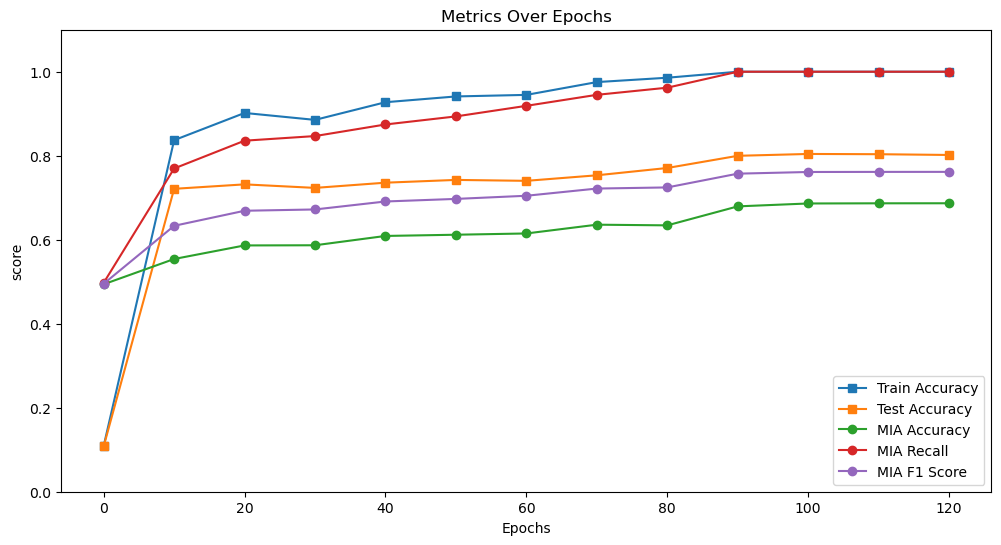

In [18]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def download_checkpoint(checkpoint_dir, net, epoch):
    """Download a specific checkpoint from a specified directory.

    Args:
      checkpoint_dir : str.
        Directory containing checkpoints.
      net : nn.Module.
        Model to load the checkpoint into.
      epoch : int.
        Epoch number to download.
    """
    checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch}.pth")
    net.load_state_dict(torch.load(checkpoint_path))
    print(f"Checkpoint at epoch {epoch} loaded.")

def compute_metrics(net, train_loader, test_loader, forget_loader):
    # Calculate accuracies
    train_acc = accuracy(net, train_loader)
    time.sleep(1)
    test_acc = accuracy(net, test_loader)
    time.sleep(1)

    # Calculate losses
    forget_losses = compute_losses(net, forget_loader)
    time.sleep(1)
    test_losses = compute_losses(net, test_loader)
    time.sleep(1)

    # Calculate MIA scores
    samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)
    mia_scores = simple_mia_customized(samples_mia, labels_mia)

    return train_acc, test_acc, mia_scores

def compute_and_plot_metrics(net, train_loader, test_loader, forget_loader, checkpoint_epochs):
    train_accuracies = []
    test_accuracies = []
    mia_accuracies = []
    mia_recalls = []
    mia_f1_scores = []

    for epoch in checkpoint_epochs:
        # Download checkpoint
        download_checkpoint(checkpoint_dir, net, epoch)

        # Compute metrics once and reuse
        train_acc, test_acc, mia_scores = compute_metrics(net, train_loader, test_loader, forget_loader)

        # Store results
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        mia_accuracies.append(mia_scores['accuracy'])
        mia_recalls.append(mia_scores['recall'])
        mia_f1_scores.append(mia_scores['f1_score'])

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(checkpoint_epochs, train_accuracies, label='Train Accuracy', marker='s')
    plt.plot(checkpoint_epochs, test_accuracies, label='Test Accuracy', marker='s')
    plt.plot(checkpoint_epochs, mia_accuracies, label='MIA Accuracy', marker='o')
    plt.plot(checkpoint_epochs, mia_recalls, label='MIA Recall', marker='o')
    plt.plot(checkpoint_epochs, mia_f1_scores, label='MIA F1 Score', marker='o')

    plt.title("Metrics Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("score")
    plt.ylim(0, 1.1)

    plt.legend()
    plt.show()

# Usage example
checkpoint_dir = "check_point_cos"  # Replace with your actual checkpoint directory
checkpoint_epochs = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]  # Replace with the epochs you want to analyze

# Create and initialize your model
net = model

# Call the function to compute and plot metrics
compute_and_plot_metrics(net, train_loader, test_loader, forget_loader, checkpoint_epochs)
